# **Importing Libraries**

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import InceptionResNetV2, ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Explainability 
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

# Your model definition and training code goes here
# For example:
# model = models.Sequential([...])
# model.compile(...)
# model.fit(...)

# If you want to save the model locally, you can use:
# model.save('my_model.h5')

# If you want to load the model later:
# model = tf.keras.models.load_model('my_model.h5')

# If you want to visualize the model's performance:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

/Users/sohailqureshi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **InceptionResnet V2 Model**

In [6]:
import os
import tensorflow as tf

# Base path for the dataset (relative path since the dataset is in the same folder as the notebook)
base_path = './real-vs-fake'  # Adjust this if the dataset is in a different location

# Function to return the data according to the directory
def get_data(base_path, dir_name):
    data = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_path, dir_name),  # Construct the full path to the directory
        seed=42,  # Random seed for reproducibility
        image_size=(224, 224),  # Resize images to 224x224
        batch_size=32,  # Batch size
        shuffle=True  # Shuffle the data
    )
    return data

# Load the datasets
train_full_ds = get_data(base_path, 'train')
valid_full_ds = get_data(base_path, 'valid')
test_full_ds = get_data(base_path, 'test')

# Print the class names (optional)
print("Class names:", train_full_ds.class_names)

# Example: Inspect the first batch of training data
for images, labels in train_full_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Found 100000 files belonging to 2 classes.


2025-03-24 23:59:13.480686: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-24 23:59:13.480767: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-24 23:59:13.481158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1742840953.481498  286212 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742840953.482109  286212 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Class names: ['fake', 'real']
Images shape: (32, 224, 224, 3)
Labels shape: (32,)


2025-03-24 23:59:15.629810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Extract class names before applying map
class_names = train_full_ds.class_names
print("Class names:", class_names)

# Normalize the datasets
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_full_ds = train_full_ds.map(normalize)
valid_full_ds = valid_full_ds.map(normalize)
test_full_ds = test_full_ds.map(normalize)

# Check the output format
for images, labels in train_full_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample label (binary):", labels[0])

Class names: ['fake', 'real']
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Sample label (binary): tf.Tensor(1, shape=(), dtype=int32)


2025-03-24 23:59:21.384551: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Improves training performance by overlapping data preprocessing and model execution
def optimize_input(train,valid,test):
    AUTOTUNE = tf.data.AUTOTUNE

    train = train.prefetch(buffer_size=AUTOTUNE)
    valid = valid.prefetch(buffer_size=AUTOTUNE)
    test = test.prefetch(buffer_size=AUTOTUNE)

    return train,valid,test


train_full_ds,valid_full_ds,test_full_ds = optimize_input(train_full_ds,valid_full_ds,test_full_ds)

In [9]:
def create_model():
    # Load the pre-trained base model with top layers excluded
    base_model = InceptionResNetV2(
        input_shape=(224, 224, 3),
        include_top=False,  
        weights='imagenet'
    )

    # Freeze the first 450 layers of the base model and train the rest
    for layer in base_model.layers[:450]:
        layer.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,                               
        layers.GlobalAveragePooling2D(),         
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Dense layer
        layers.BatchNormalization(),            
        layers.Dropout(0.5),                     
        layers.Dense(1, activation='sigmoid')    
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## **InceptionResnet V2 Training**

In [10]:
model = create_model()

# Stop if the validation loss is not improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history_fine_tune = model.fit(
    train_full_ds,             
    validation_data=valid_full_ds,  
    epochs=8,                  
    callbacks=[early_stopping]
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step
Epoch 1/8


2025-03-25 00:00:45.313799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6024s 2s/step - accuracy: 0.8642 - loss: 3.6084 - val_accuracy: 0.9675 - val_loss: 0.1241
Epoch 2/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5899s 2s/step - accuracy: 0.9719 - loss: 0.0912 - val_accuracy: 0.9809 - val_loss: 0.0592
Epoch 3/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5913s 2s/step - accuracy: 0.9877 - loss: 0.0385 - val_accuracy: 0.9800 - val_loss: 0.0587
Epoch 4/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5884s 2s/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9815 - val_loss: 0.0519
Epoch 5/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5945s 2s/step - accuracy: 0.9943 - loss: 0.0194 - val_accuracy: 0.9802 - val_loss: 0.0585
Epoch 6/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5785s 2s/step - accuracy: 0.9955 - loss: 0.0155 - val_accuracy: 0.9789 - val_loss: 0.0606
Epoch 7/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6672s 2s/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9664 - val_loss: 0.1090


In [11]:
model.save("deepfake_classifier_inceptionresnet.keras")

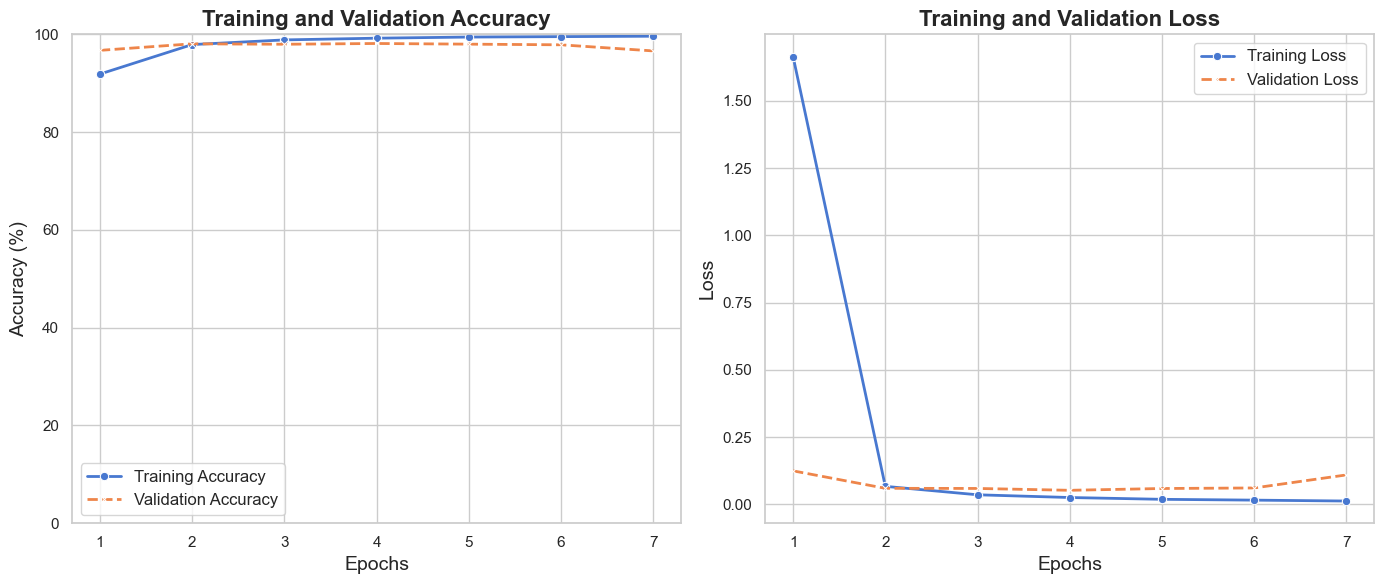

In [12]:
def acc_loss_plot(history):
    # Get the number of epochs from history
    epochs = range(1, len(history.history["accuracy"]) + 1)
    
    # Set up Seaborn style
    sns.set(style="whitegrid", palette="muted")
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    sns.lineplot(
        x=epochs,
        y=[val * 100 for val in history.history["accuracy"]], 
        label='Training Accuracy', linewidth=2, marker="o"
    )
    sns.lineplot(
        x=epochs,
        y=[val * 100 for val in history.history["val_accuracy"]], 
        label='Validation Accuracy', linewidth=2, linestyle='--', marker="x"
    )
    plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)  # Display percentages
    plt.ylim(0, 100)  # Set y-axis range from 0 to 100
    plt.legend(fontsize=12)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    sns.lineplot(
        x=epochs, 
        y=history.history["loss"], 
        label='Training Loss', linewidth=2, marker="o"
    )
    sns.lineplot(
        x=epochs, 
        y=history.history["val_loss"], 
        label='Validation Loss', linewidth=2, linestyle='--', marker="x"
    )
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

acc_loss_plot(history_fine_tune)

In [ ]:
# model.save("deepfake_classifier_inceptionresnet.keras")

In [ ]:
# # Upload the file to your drive and install it from there
# def upload_model(model_name,model_ext, model_file_path):
    
#     auth.authenticate_user()
#     drive_service = build('drive', 'v3')

#     file_metadata = {"name": f"{model_name}.{model_ext}"}
#     media = MediaFileUpload(model_file_path, resumable=True)
#     file = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()

#     print("Uploaded. File ID:", file.get("id"))

In [ ]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

def get_file_id(file_name):
    try:
        # Authenticate user
        auth.authenticate_user()

        # Build the Google Drive service
        drive_service = build('drive', 'v3')

        # List all files in Google Drive
        results = drive_service.files().list(q=f"name='{file_name}'", fields="files(id, name)").execute()
        files = results.get('files', [])

        if not files:
            print('No files found.')
            return None
        else:
            # Print all matching files and their IDs
            for file in files:
                print(f"Found file: {file['name']} (ID: {file['id']})")
                # Return the first matching file ID
                return file['id']
                
    except HttpError as error:
        print(f"An error occurred: {error}")
        return None

# Example usage:
file_name = "InceptionResnet_DeepFake.h5"  # Change this to the model name you used
file_id = get_file_id(file_name)

if file_id:
    print(f"File ID: {file_id}")
else:
    print("File not found!")


Found file: InceptionResnet_DeepFake.h5 (ID: 1KrvI9N3coi1F7BHjOXM1NM9EvZ68bwz_)
File ID: 1KrvI9N3coi1F7BHjOXM1NM9EvZ68bwz_


In [ ]:
# import gdown

# file_id = '1KrvI9N3coi1F7BHjOXM1NM9EvZ68bwz_'  # Replace with your file ID
# output_path = '/kaggle/working/InceptionResnet_DeepFake.h5'  # Replace with your desired file path

# gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KrvI9N3coi1F7BHjOXM1NM9EvZ68bwz_
From (redirected): https://drive.google.com/uc?id=1KrvI9N3coi1F7BHjOXM1NM9EvZ68bwz_&confirm=t&uuid=c4d1855e-6e55-4865-bdcd-6d98b4691871
To: /kaggle/working/InceptionResnet_DeepFake.h5
100%|██████████| 529M/529M [00:06<00:00, 77.0MB/s] 


'/kaggle/working/InceptionResnet_DeepFake.h5'

## **InceptionResnet V2 Evaluation**

In [13]:
# Model Evaluation 
loss, accuracy = model.evaluate(test_full_ds, verbose=1)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 246s 384ms/step - accuracy: 0.9821 - loss: 0.0515
Test Loss: 0.0505
Test Accuracy: 0.9827


# **Explainable AI (XAI)**

## **About XAI**
**XAI** is a technique used to explain the behavior of black-box models, helping us understand which features in images influenced the model's decision to classify them as fake or real. This process involves the following steps:

1. **Select an image** from a known class (e.g., a "Fake" image).
2. **Perturb the image** by creating different versions, such as masking parts of the image.
3. **Make predictions** on these perturbed images.
4. **Train a simple model** using the predictions made on the perturbed images.
5. The simple model then identifies **the most important regions** of the image that contributed to the classification as "Fake."

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


  1%|          | 10/1000 [00:12<20:55,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


  2%|▏         | 20/1000 [00:13<08:51,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  3%|▎         | 30/1000 [00:13<04:54,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|▍         | 40/1000 [00:13<03:03,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|▌         | 50/1000 [00:13<02:02,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|▌         | 60/1000 [00:13<01:26, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|▋         | 70/1000 [00:13<01:03, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  8%|▊         | 80/1000 [00:14<00:48, 18.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|▉         | 90/1000 [00:14<00:38, 23.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 10%|█         | 100/1000 [00:14<00:35, 25.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 11%|█         | 110/1000 [00:14<00:30, 29.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 12%|█▏        | 120/1000 [00:15<00:26, 33.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|█▎        | 130/1000 [00:15<00:22, 37.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 14%|█▍        | 140/1000 [00:15<00:20, 41.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 15%|█▌        | 150/1000 [00:15<00:19, 44.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|█▌        | 160/1000 [00:15<00:18, 45.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 17%|█▋        | 170/1000 [00:16<00:17, 46.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 18%|█▊        | 180/1000 [00:16<00:16, 48.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 19%|█▉        | 190/1000 [00:16<00:16, 49.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 20%|██        | 200/1000 [00:16<00:16, 49.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 21%|██        | 210/1000 [00:16<00:16, 47.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 22%|██▏       | 220/1000 [00:17<00:16, 48.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|██▎       | 230/1000 [00:17<00:15, 48.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 24%|██▍       | 240/1000 [00:17<00:15, 49.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██▌       | 250/1000 [00:17<00:14, 50.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 26%|██▌       | 260/1000 [00:17<00:14, 50.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 27%|██▋       | 270/1000 [00:18<00:14, 51.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|██▊       | 280/1000 [00:18<00:13, 52.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██▉       | 290/1000 [00:18<00:13, 52.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 30%|███       | 300/1000 [00:18<00:13, 52.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|███       | 310/1000 [00:18<00:12, 53.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 32%|███▏      | 320/1000 [00:19<00:12, 53.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 33%|███▎      | 330/1000 [00:19<00:12, 53.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|███▍      | 340/1000 [00:19<00:12, 52.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███▌      | 350/1000 [00:19<00:12, 53.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|███▌      | 360/1000 [00:19<00:12, 53.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 37%|███▋      | 370/1000 [00:19<00:11, 53.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|███▊      | 380/1000 [00:20<00:11, 53.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 39%|███▉      | 390/1000 [00:20<00:11, 53.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|████      | 400/1000 [00:20<00:11, 53.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 41%|████      | 410/1000 [00:20<00:10, 53.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████▏     | 420/1000 [00:20<00:10, 53.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 43%|████▎     | 430/1000 [00:21<00:10, 54.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 44%|████▍     | 440/1000 [00:21<00:10, 53.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|████▌     | 450/1000 [00:21<00:10, 53.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 46%|████▌     | 460/1000 [00:21<00:10, 53.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 47%|████▋     | 470/1000 [00:21<00:11, 48.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 48%|████▊     | 480/1000 [00:22<00:12, 43.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 49%|████▉     | 490/1000 [00:22<00:12, 41.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 50%|█████     | 500/1000 [00:22<00:11, 41.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 51%|█████     | 510/1000 [00:22<00:11, 43.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 52%|█████▏    | 520/1000 [00:23<00:10, 45.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|█████▎    | 530/1000 [00:23<00:09, 47.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 54%|█████▍    | 540/1000 [00:23<00:09, 48.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 55%|█████▌    | 550/1000 [00:23<00:09, 49.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 56%|█████▌    | 560/1000 [00:23<00:08, 50.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|█████▋    | 570/1000 [00:24<00:08, 50.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 58%|█████▊    | 580/1000 [00:24<00:08, 49.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 59%|█████▉    | 590/1000 [00:24<00:08, 49.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 60%|██████    | 600/1000 [00:24<00:07, 50.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 61%|██████    | 610/1000 [00:24<00:07, 51.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 62%|██████▏   | 620/1000 [00:25<00:07, 51.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 63%|██████▎   | 630/1000 [00:25<00:07, 51.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 64%|██████▍   | 640/1000 [00:25<00:06, 51.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 65%|██████▌   | 650/1000 [00:25<00:06, 51.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 66%|██████▌   | 660/1000 [00:25<00:06, 51.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 67%|██████▋   | 670/1000 [00:25<00:06, 51.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 68%|██████▊   | 680/1000 [00:26<00:06, 51.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 69%|██████▉   | 690/1000 [00:26<00:06, 51.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 70%|███████   | 700/1000 [00:26<00:05, 52.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 71%|███████   | 710/1000 [00:26<00:05, 52.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 72%|███████▏  | 720/1000 [00:26<00:05, 52.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 73%|███████▎  | 730/1000 [00:27<00:05, 51.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 74%|███████▍  | 740/1000 [00:27<00:05, 51.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 75%|███████▌  | 750/1000 [00:27<00:04, 51.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 76%|███████▌  | 760/1000 [00:27<00:04, 49.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 77%|███████▋  | 770/1000 [00:27<00:04, 50.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 78%|███████▊  | 780/1000 [00:28<00:04, 50.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 79%|███████▉  | 790/1000 [00:28<00:04, 51.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|████████  | 800/1000 [00:28<00:03, 51.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 81%|████████  | 810/1000 [00:28<00:03, 50.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 82%|████████▏ | 820/1000 [00:28<00:03, 51.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 83%|████████▎ | 830/1000 [00:29<00:03, 51.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 84%|████████▍ | 840/1000 [00:29<00:03, 51.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 85%|████████▌ | 850/1000 [00:29<00:02, 51.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 86%|████████▌ | 860/1000 [00:29<00:02, 52.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 87%|████████▋ | 870/1000 [00:29<00:02, 50.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 88%|████████▊ | 880/1000 [00:30<00:02, 51.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 89%|████████▉ | 890/1000 [00:30<00:02, 51.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 90%|█████████ | 900/1000 [00:30<00:02, 49.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 91%|█████████ | 910/1000 [00:30<00:01, 47.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 92%|█████████▏| 920/1000 [00:30<00:01, 48.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 93%|█████████▎| 930/1000 [00:31<00:01, 47.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 94%|█████████▍| 940/1000 [00:31<00:01, 47.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 95%|█████████▌| 950/1000 [00:31<00:01, 43.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 96%|█████████▌| 960/1000 [00:31<00:00, 45.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 97%|█████████▋| 970/1000 [00:32<00:00, 47.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 98%|█████████▊| 980/1000 [00:32<00:00, 48.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 99%|█████████▉| 990/1000 [00:32<00:00, 46.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


100%|██████████| 1000/1000 [00:32<00:00, 30.65it/s]


Labels in explanation: dict_keys([np.int64(0)])
Predicted class index: 0


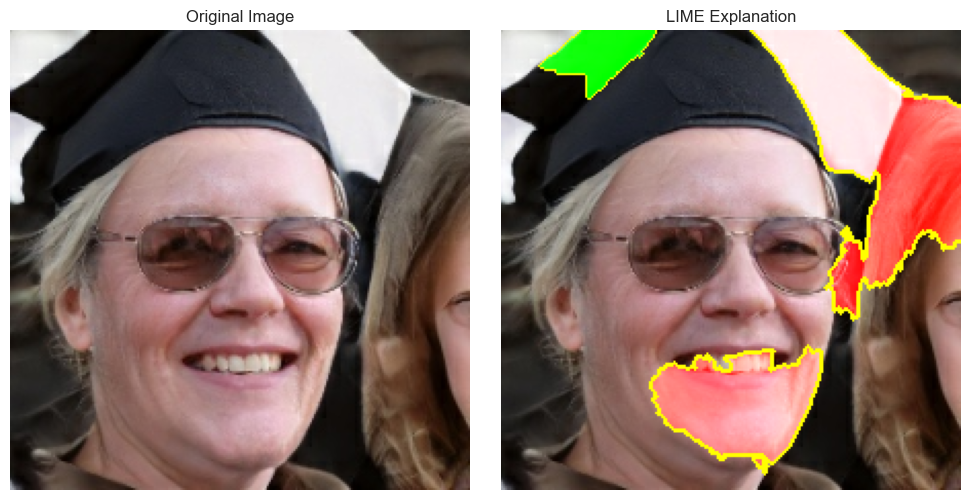

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()


def explain_image(model, image, class_names):
    # Ensuring correct img dim
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Model Prediction
    predicted_class = model.predict(image)
    predicted_class_index = (predicted_class[0] > 0.6).astype(int)  # Binary threshold for sigmoid

    # Explanation using the model's predict method
    explanation = explainer.explain_instance(
        image=image[0].astype('double'),  
        classifier_fn=model.predict,
        top_labels=1, 
        hide_color=0,
        num_samples=1000
    )

    # Check labels in explanation
    print("Labels in explanation:", explanation.local_exp.keys())
    print("Predicted class index:", predicted_class_index[0])

    # Ensure the label exists in the explanation
    label = predicted_class_index[0]
    if label not in explanation.local_exp:
        print(f"Label {label} not in explanation. Using a fallback.")
        label = next(iter(explanation.local_exp.keys()))  # Fallback if label not found

    # Get the explanation for the predicted or fallback class
    temp, mask = explanation.get_image_and_mask(
        label=label,  
        positive_only=False,
        num_features=5,
        hide_rest=False
    )

    # Plot the original image and the LIME explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(image[0])  
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(mark_boundaries(temp, mask))  
    axes[1].set_title("LIME Explanation")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Use an image from the test dataset
for images, labels in test_full_ds.take(2):  # Iterate over the test dataset
    explain_image(model, images[0], class_names)
    break  # Use only one image from the dataset


# **InceptionResnet Generalize**

In [ ]:
# Assuring that the used datasets for generalization are not the same as one used for training
import hashlib
def calculate_file_hash(file_path):
    """Calculate the MD5 hash of a file."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def compare_with_valid(dir1, dir2_valid):
    """Compare train, test, and valid subfolders of dir1 with the valid subfolder of dir2."""
    subfolders = ['train', 'test', 'valid']  # Subfolders to compare in dir1
    dir2_valid_hashes = {}
    
    # Calculate hashes for all files in dir2/valid
    for root, _, files in os.walk(dir2_valid):
        for file in files:
            file_path = os.path.join(root, file)
            file_hash = calculate_file_hash(file_path)
            dir2_valid_hashes[file_hash] = file_path

    # Compare each subfolder in dir1 with dir2/valid
    for subfolder in subfolders:
        dir1_subfolder = os.path.join(dir1, subfolder)
        if not os.path.exists(dir1_subfolder):
            print(f"Subfolder '{subfolder}' is missing in dir1.")
            continue

        print(f"Comparing dir1/{subfolder} with dir2/valid...")
        dir1_hashes = {}

        # Calculate hashes for files in dir1/{subfolder}
        for root, _, files in os.walk(dir1_subfolder):
            for file in files:
                file_path = os.path.join(root, file)
                file_hash = calculate_file_hash(file_path)
                dir1_hashes[file_hash] = file_path

        # Find common hashes between dir1/{subfolder} and dir2/valid
        common_hashes = set(dir1_hashes.keys()) & set(dir2_valid_hashes.keys())

        if common_hashes:
            print(f"Duplicate files found between dir1/{subfolder} and dir2/valid:")
            for file_hash in common_hashes:
                print(f"  {dir1_hashes[file_hash]} and {dir2_valid_hashes[file_hash]}")
        else:
            print(f"No duplicate files found between dir1/{subfolder} and dir2/valid.")

            

dir1 = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"
dir2 = "/kaggle/input/real-vs-ai-generated-faces/dataset/val"
compare_with_valid(dir1, dir2)


Comparing dir1/train with dir2/valid...
No duplicate files found between dir1/train and dir2/valid.
Comparing dir1/test with dir2/valid...
No duplicate files found between dir1/test and dir2/valid.
Comparing dir1/valid with dir2/valid...
No duplicate files found between dir1/valid and dir2/valid.


In [18]:
import os
import hashlib

def calculate_file_hash(file_path):
    """Calculate the MD5 hash of a file."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def compare_with_valid(train_test_dirs, valid_dir):
    """Compare train/test subfolders (real, fake) with valid subfolders (real, fake)."""
    valid_hashes = {}

    # Calculate hashes for all files in valid/real and valid/fake
    for category in ['real', 'fake']:
        category_path = os.path.join(valid_dir, category)
        if not os.path.exists(category_path):
            print(f"Skipping missing folder: {category_path}")
            continue

        for root, _, files in os.walk(category_path):
            for file in files:
                file_path = os.path.join(root, file)
                file_hash = calculate_file_hash(file_path)
                valid_hashes[file_hash] = file_path  # Store hash -> file mapping

    # Compare train/test (real, fake) with valid
    for parent_dir in train_test_dirs:
        for category in ['real', 'fake']:
            category_path = os.path.join(parent_dir, category)
            if not os.path.exists(category_path):
                print(f"Skipping missing folder: {category_path}")
                continue

            print(f"Comparing {category_path} with {valid_dir}/{category}...")
            train_test_hashes = {}

            # Compute hashes for train/test images
            for root, _, files in os.walk(category_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    file_hash = calculate_file_hash(file_path)
                    train_test_hashes[file_hash] = file_path

            # Find duplicates
            common_hashes = set(train_test_hashes.keys()) & set(valid_hashes.keys())

            if common_hashes:
                print(f"Duplicate files found between {category_path} and {valid_dir}/{category}:")
                for file_hash in common_hashes:
                    print(f"  {train_test_hashes[file_hash]} <--> {valid_hashes[file_hash]}")
            else:
                print(f"No duplicate files found between {category_path} and {valid_dir}/{category}.")

# Set paths based on your structure
dataset_path = os.path.abspath("real-vs-fake")  # Assuming dataset is in the same folder
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")
valid_dir = os.path.join(dataset_path, "valid")

# Compare train & test (real, fake) with valid (real, fake)
compare_with_valid([train_dir, test_dir], valid_dir)


Comparing /Users/sohailqureshi/anas/real-vs-fake/train/real with /Users/sohailqureshi/anas/real-vs-fake/valid/real...
No duplicate files found between /Users/sohailqureshi/anas/real-vs-fake/train/real and /Users/sohailqureshi/anas/real-vs-fake/valid/real.
Comparing /Users/sohailqureshi/anas/real-vs-fake/train/fake with /Users/sohailqureshi/anas/real-vs-fake/valid/fake...
No duplicate files found between /Users/sohailqureshi/anas/real-vs-fake/train/fake and /Users/sohailqureshi/anas/real-vs-fake/valid/fake.
Comparing /Users/sohailqureshi/anas/real-vs-fake/test/real with /Users/sohailqureshi/anas/real-vs-fake/valid/real...
No duplicate files found between /Users/sohailqureshi/anas/real-vs-fake/test/real and /Users/sohailqureshi/anas/real-vs-fake/valid/real.
Comparing /Users/sohailqureshi/anas/real-vs-fake/test/fake with /Users/sohailqureshi/anas/real-vs-fake/valid/fake...
No duplicate files found between /Users/sohailqureshi/anas/real-vs-fake/test/fake and /Users/sohailqureshi/anas/real-

In [ ]:
base_path = "/kaggle/input/real-vs-ai-generated-faces/dataset/"

generalize = tf.keras.utils.image_dataset_from_directory(
    
    os.path.join(base_path,"val"),
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

class_names = generalize.class_names
print("Class names:", class_names)

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label


generalize = generalize.map(normalize)

for images, labels in generalize.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample label (binary):", labels[0])

Found 1218 files belonging to 2 classes.
Class names: ['fake', 'real']
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Sample label (binary): tf.Tensor(1, shape=(), dtype=int32)


In [19]:
import os
import tensorflow as tf

# Define the local dataset path
base_path = os.path.abspath("real-vs-fake")  # Ensures it works from any directory

# Load images from valid/ (which contains 'real' and 'fake' subdirectories)
generalize = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_path, "valid"),  # Path to the valid dataset
    seed=42,
    image_size=(224, 224),  # Resize images
    batch_size=32,
    shuffle=True
)

# Get class names (should be ['fake', 'real'])
class_names = generalize.class_names
print("Class names:", class_names)

# Normalize images to [0,1] range
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply normalization
generalize = generalize.map(normalize)

# Display dataset info
for images, labels in generalize.take(1):  # Take a single batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample label (binary):", labels[0].numpy())  # Convert tensor to numpy for printing


Found 20000 files belonging to 2 classes.
Class names: ['fake', 'real']
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Sample label (binary): 1


In [20]:
# Evaluate the model generalization on a new dataset
loss, accuracy = model.evaluate(generalize, verbose=1)

# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4%}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 401ms/step - accuracy: 0.9812 - loss: 0.0536
Test Loss: 0.0519
Test Accuracy: 98.1550%


# **References & Streamlit App**

1. Heidari, A., Navimipour, N. J., Dag, H., & Unal, M. (2023). *Deepfake detection using deep learning methods: A systematic and comprehensive review*. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, **14**(2). [https://doi.org/10.1002/widm.1520](https://doi.org/10.1002/widm.1520)

2. Abir, W. H., et al. (2022). *Detecting deepfake images using deep learning techniques and explainable AI methods*. Intelligent Automation & Soft Computing, **35**(2), 2151–2169. [https://doi.org/10.32604/iasc.2023.029653](https://doi.org/10.32604/iasc.2023.029653)

3. Salih, A. M., Raisi-Estabragh, Z., Galazzo, I. B., Radeva, P., Petersen, S. E., Lekadir, K., & Menegaz, G. (2024). *A Perspective on Explainable Artificial Intelligence Methods: SHAP and LIME*. arXiv. [https://arxiv.org/abs/2305.02012](https://arxiv.org/abs/2305.02012)

4. https://deep-fake-classification-cf3lbfh3bvqmhjts9q93tu.streamlit.app/
